In [1]:
import pandas as pd
import geopandas as gpd

import numpy as np

from shapely.geometry import Point, Polygon, MultiPolygon
from shapely.ops import unary_union

import matplotlib.pyplot as plt

In [2]:
def create_point_grid(polygon, step):
    
    x_min, y_min, x_max, y_max = polygon.bounds
    
    x = np.arange(x_min, x_max - step, step) + step
    y = np.arange(y_min, y_max - step, step) + step
    
    X, Y = np.meshgrid(x, y) 
    
    all_points = np.vstack([X.ravel(), Y.ravel()]).T
    all_points = [Point(point) for point in all_points]
    
    points = []
    
    for point in all_points:
        if point.within(polygon):
            points.append(point)
    
    return points

In [3]:
def get_outer_contour(data):
    country = []
    
    for ind, row in data.iterrows():   
        poly = row.geometry
        country.append(poly)        
                
    country = unary_union(country)
    
    return country[0]

In [17]:
def plot_map(filename, 
             data, 
             border,
             borderdata=None,
             shuffle=True,
             gridstep=0.04,
             figsize=(10, 20),
             markersize=40,
             fontsize=16,
             fontcolor='0.95',
             activecolor='#e98668',
             recoveredcolor='#29bbcf',
             bordercolor='#d64f5f',
             background=None,
             edge=None,
             dpi=300,
             transparent=False
            ):
    fig, ax = plt.subplots(figsize=figsize)
    marker_size = markersize
    if borderdata is None:
        borderdata = data
        
    for ind, row in data.iterrows():        
        poly = row.geometry       
        points = create_point_grid(poly, gridstep)
               
        if shuffle:
            marker='o'
            np.random.shuffle(points)
        else:
            marker='s'

        x = [point.x for point in points]
        y = [point.y for point in points]
        
        # Selectionn of points for coloring
        try:
            proportion_1 = (row['active_cases'] + row['recovered']) / row['population']
            proportion_2 = row['recovered'] / (row['active_cases'] + row['recovered'])
    
            exposed_X = x[0 : round(len(x) * proportion_1) + 1]
            exposed_Y = y[0 : round(len(y) * proportion_1) + 1]
                
            recovered_X = exposed_X[0 : round(len(exposed_X) * proportion_2) + 1]
            recovered_Y = exposed_Y[0 : round(len(exposed_Y) * proportion_2) + 1]
            
            active_X = exposed_X[round(len(exposed_X) * proportion_2) + 1 : len(exposed_X) + 1]
            active_Y = exposed_Y[round(len(exposed_Y) * proportion_2) + 1 : len(exposed_Y) + 1]
          
            plt.scatter(recovered_X, recovered_Y,
                        color=recoveredcolor, marker=marker, s=marker_size, zorder=2)  
            plt.scatter(active_X, active_Y,
                        color=activecolor, marker=marker, s=marker_size*2, zorder=2)
        except:
            pass
    
    for ind, row in borderdata.iterrows():
        poly = row.geometry 
        try:
            plt.plot(*poly.exterior.xy, color=bordercolor, zorder=1)
        except:
            for geom in poly:
                plt.plot(*geom.exterior.xy, color=bordercolor, zorder=1)
        x_min, y_min, x_max, y_max = poly.bounds
        plt.annotate(row[0], (x_min + (x_max - x_min) / 3, (y_min + y_max) / 2),
                     color=fontcolor, fontsize=fontsize)
        
    plt.plot(*border.exterior.xy, color=bordercolor, linewidth=3, zorder=3)    
        
    #ax.set_facecolor(background)
    plt.axis('off')
    
    plt.savefig(filename,
                dpi=dpi,
                edgecolor=edge,
                facecolor=background,
                transparent=transparent
                )

## Data
### 1. COVID data 

We are interested in proportions, therefore we name a new variable as *prop_data*

In [5]:
#prop_data = pd.read_csv("19-01-2021_data.csv")
prop_data = pd.read_csv("fill_other_points.csv")
prop_data

,concelho,total,population,active_cases,recovered
0,ABRANTES,1532,35130,306,1226
1,AGUIAR DA BEIRA,732,46075,695,37
2,ALANDROAL,345,4652,291,54
3,ALBERGARIA-A-VELHA,1631,4992,95,1536
4,ALBUFEIRA,2092,24144,246,1846
...,...,...,...,...,...
300,VOUZELA,719,4023,40,679
301,ÁGUEDA,3667,7746,87,3580
302,ÉVORA,3918,97249,1601,2317
303,ÍLHAVO,2735,23897,215,2520


In [6]:
prop_data = prop_data[['concelho', 'population', 'active_cases', 'recovered']]#.rename(columns={'concelho':'NAME_2'})
prop_data.head(2)

,concelho,population,active_cases,recovered
0,ABRANTES,35130,306,1226
1,AGUIAR DA BEIRA,46075,695,37


### 2. Geo data (shape polygons)

In [7]:
#por_geo = "ContinenteConcelhos.geojson"
por_geo = "concelhos-shapefile/concelhos.shp"

# Lisboa coordinates - for initial position of folium map
#lis_latitude = 38.71667
#lis_longitude = -9.13333

In [8]:
port_gdf = gpd.read_file(por_geo, encoding='utf-8')
port_gdf = port_gdf[['NAME_1', 'NAME_2', 'geometry']]
port_gdf.rename(columns={'NAME_1':'distrito', 'NAME_2':'concelho'}, inplace=True)

port_gdf['concelho'] = port_gdf['concelho'].str.upper()
port_gdf.head(2)

,distrito,concelho,geometry
0,Évora,ÉVORA,"POLYGON ((-7.79291 38.76507, -7.79287 38.76506..."
1,Évora,ALANDROAL,"POLYGON ((-7.25937 38.77351, -7.25921 38.77343..."


### 3. Merge of Data

In [9]:
port_gdf = port_gdf.merge(prop_data, on='concelho', how='left')
port_gdf.head(2)

,distrito,concelho,geometry,population,active_cases,recovered
0,Évora,ÉVORA,"POLYGON ((-7.79291 38.76507, -7.79287 38.76506...",97249.0,1601.0,2317.0
1,Évora,ALANDROAL,"POLYGON ((-7.25937 38.77351, -7.25921 38.77343...",4652.0,291.0,54.0


## District level

In [10]:
port_gdf_dist = port_gdf.copy()

port_gdf_dist = pd.DataFrame([port_gdf_dist.groupby('distrito')['geometry'].apply(unary_union),
                              port_gdf_dist.groupby('distrito')['population'].sum(),
                              port_gdf_dist.groupby('distrito')['active_cases'].sum(),
                              port_gdf_dist.groupby('distrito')['recovered'].sum()]
                              ).T.reset_index()

madeira_gdf_dist = port_gdf_dist[port_gdf_dist.distrito == 'Madeira']
port_gdf_dist = port_gdf_dist[port_gdf_dist.distrito != 'Madeira']

azores_gdf_dist = port_gdf_dist[port_gdf_dist.distrito == 'Azores']
port_gdf_dist = port_gdf_dist[port_gdf_dist.distrito != 'Azores']

port_gdf_dist.head(1)

,distrito,geometry,population,active_cases,recovered
0,Aveiro,(POLYGON ((-8.354143142700138 40.3956069946290...,515373,6997,55097


## Municipality (concelho) level

In [11]:
port_gdf_conc = port_gdf.copy()

madeira_gdf_conc = port_gdf_conc[port_gdf_conc.distrito == 'Madeira']
port_gdf_conc = port_gdf_conc[port_gdf_conc.distrito != 'Madeira']

azores_gdf_conc = port_gdf_conc[port_gdf_conc.distrito == 'Azores']
port_gdf_conc = port_gdf_conc[port_gdf_conc.distrito != 'Azores']

port_gdf_conc.head(1)

,distrito,concelho,geometry,population,active_cases,recovered
0,Évora,ÉVORA,"POLYGON ((-7.79291 38.76507, -7.79287 38.76506...",97249.0,1601.0,2317.0


## Plot

In [12]:
Portugal = get_outer_contour(port_gdf_dist)
#Madeira = get_outer_contour()
#Azores = get_outer_contour()

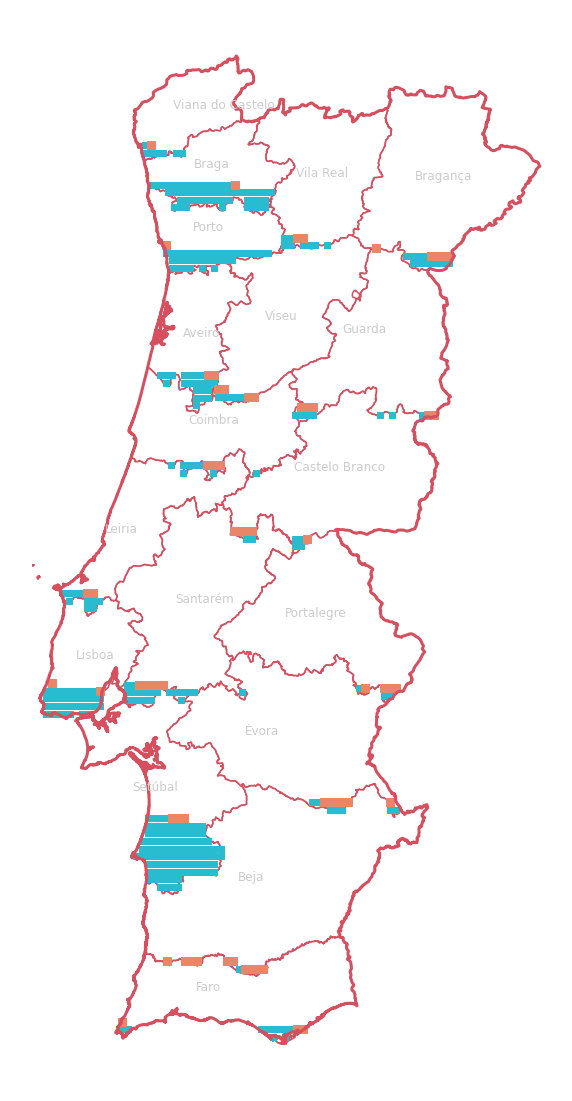

In [13]:
plot_map('map_shuffle_off.png', port_gdf_dist, Portugal, shuffle=False, background='#333333')

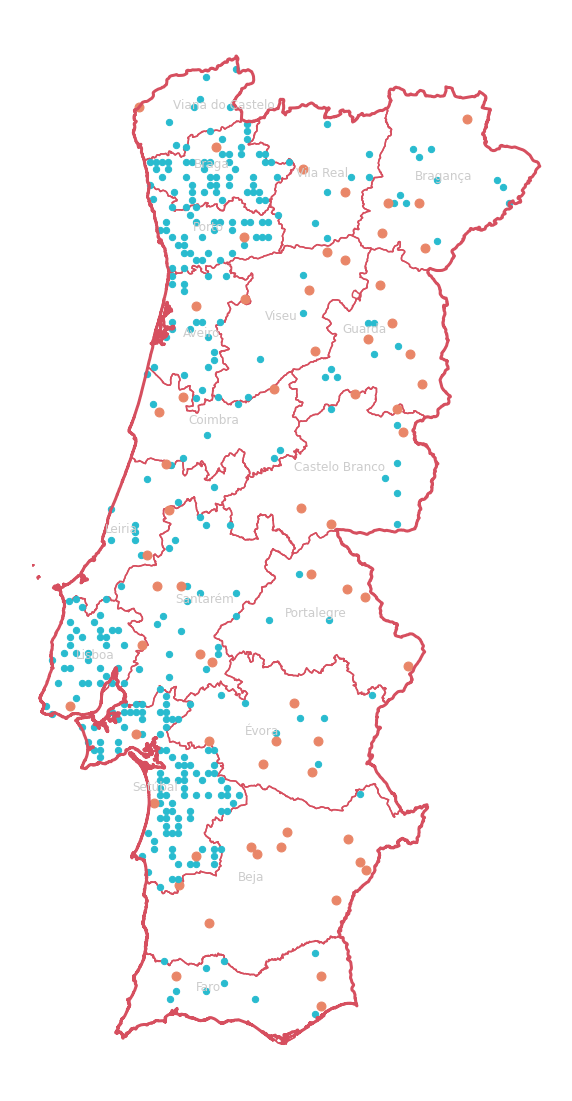

In [14]:
plot_map('map_districts.png', port_gdf_dist, Portugal, background='#333333')

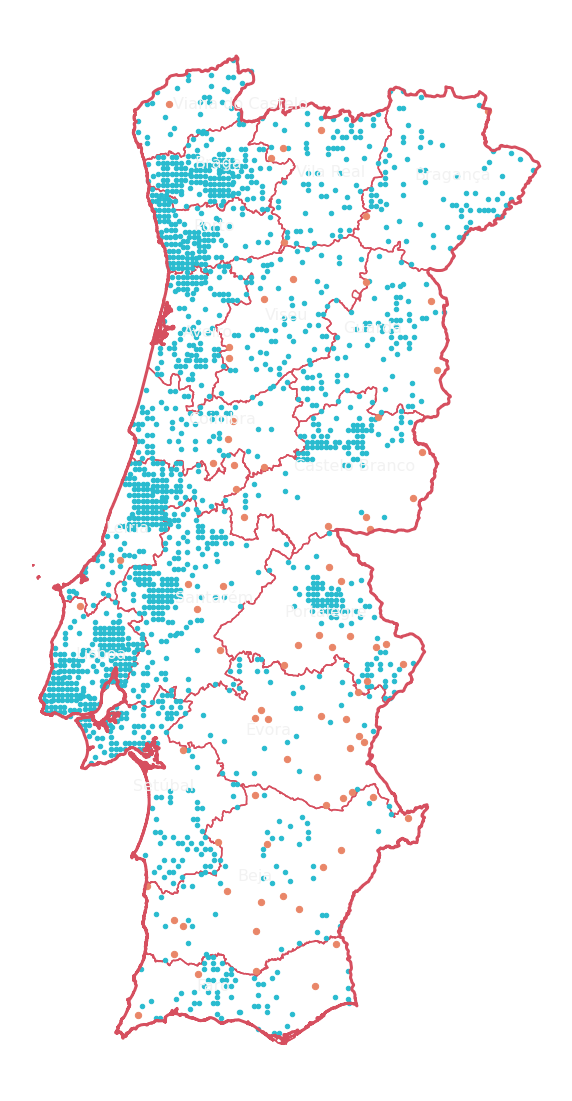

In [18]:
plot_map('map_concelhos.png',
         port_gdf_conc,
         Portugal,
         borderdata=port_gdf_dist, # plot only district borders
         gridstep=0.03,
         markersize=20,
         background='#333333')

In [16]:
port_gdf_conc[port_gdf_conc.recovered > (port_gdf_conc.population - port_gdf_conc.recovered - port_gdf_conc.active_cases)]

,distrito,concelho,geometry,population,active_cases,recovered
29,Aveiro,SANTA MARIA DA FEIRA,"POLYGON ((-8.43639 41.04243, -8.43506 41.04099...",21295.0,286.0,15783.0
67,Braga,BARCELOS,"POLYGON ((-8.62837 41.65084, -8.62799 41.65081...",18748.0,184.0,15414.0
68,Braga,BRAGA,"POLYGON ((-8.35704 41.61721, -8.35661 41.61719...",4998.0,112.0,19262.0
69,Braga,BRAGA,"POLYGON ((-8.31783 41.54539, -8.31739 41.54216...",4998.0,112.0,19262.0
74,Braga,PÓVOA DE LANHOSO,"POLYGON ((-8.25929 41.65341, -8.25949 41.65261...",2342.0,9.0,2930.0
95,Castelo Branco,FUNDÃO,"POLYGON ((-7.28483 40.27185, -7.28473 40.27163...",2974.0,42.0,1881.0
159,Leiria,LEIRIA,"POLYGON ((-8.88918 39.94897, -8.87677 39.94180...",1463.0,2.0,7405.0
164,Leiria,POMBAL,"POLYGON ((-8.89324 40.04406, -8.89295 40.04399...",5397.0,38.0,3289.0
166,Lisboa,ALENQUER,"POLYGON ((-9.01805 39.18840, -9.01729 39.18826...",2159.0,13.0,2828.0
167,Lisboa,AMADORA,"POLYGON ((-9.23543 38.79628, -9.23477 38.79568...",2477.0,41.0,11587.0
